# Data Science - Analysis of Metro Stations Areas in Panama City. Clustering and Classification

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1"> Introduction: Business Problem</a>

2.  <a href="#item2"> Data </a>
*	<a href="#item3">Metro Stations Data </a>
*	<a href="#item4">Foursquare API Data</a>
*	<a href="#item5">Scraping Data from the Foursquare website</a>
3.  <a href="#item6">Methodology</a>
*	<a href="#item7">Analysis of Each Station</a>
*	<a href="#item8"> K-Means Clustering Method</a>
*	<a href="#item9"> Cluster Characteristics</a>
4.  <a href="#item4">Results and Discussion</a>

5.  <a href="#item5">Conclusion</a>  
    </font>
    </div>


## 1. Introduction: Business Problem  <a id="item1"></a>

The Metro in Panama City became operational in 2014, helping the supply of the public travel demand characteristic. Despite in 2019, the second line went successfully into operation in the second quarter, we know that the development of this Metro system is a long-term process, and it carries along with it ramification of positive impacts, that could be analyze in order to maximize the opportunities. One approach that I will expand here, is the **clustering and segmentation of each metro station**, for the purpose of analyze a ratio of venues that characterize the transit of people around it. In this way I could expect as a result, **classification of the main commercial activities in its surroundings and primary usage of each station**. The information could be interest and useful in this way:
-	Find places for new business development,
-	Identify the urban structured to raise more strategies for the urban planification’s institutes,
-	Relate the travel demand characteristic in each place,
-	Boost the tourism activity by recognizing the principal venues in each station.


## 2. Data<a id="item2"></a>

To get a better approach to this problem, I will use the following data and sources:
-	List of stations and its coordinates. For this intend I will use Google Maps to get the locations and the official website of the Metro of Panama https://www.elmetrodepanama.com/linea-1/, https://www.elmetrodepanama.com/linea-2/ to get the names of each station.
-	The Foursquare API, which going to help us to get the data of the most common venues surrounding each station.
-	Foursquare Categories, https://developer.foursquare.com/docs/build-with-foursquare/categories/. I will get the data by scraping the website using BS4 library

First of all, let's download all the dependencies that we will need, before getting the data and start exploring it.

In [1]:
!pip install geopy
!pip install geocoder
!pip install folium
from geopy.geocoders import Nominatim
import folium
import geocoder
import pandas as pd
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#import seaborn for graphs
import seaborn as sns

# import k-means from clustering stage
!pip install -U scikit-learn
!pip install -U imbalanced-learn
from sklearn.cluster import KMeans

# import libraries for web scraping
!pip install lxml
!pip install html5lib
!pip install BeautifulSoup4
import html5lib
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq

print('Libraries imported.')

     |████████████████████████████████| 112kB 10.6MB/s eta 0:00:01
     |████████████████████████████████| 102kB 9.0MB/s ta 0:00:011
     |████████████████████████████████| 6.8MB 12.6MB/s eta 0:00:01
     |████████████████████████████████| 307kB 17.7MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.20.1
    Uninstalling scikit-learn-0.20.1:
      Successfully uninstalled scikit-learn-0.20.1
     |████████████████████████████████| 174kB 6.7MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 6.6MB/s eta 0:00:01
     |████████████████████████████████| 122kB 5.7MB/s eta 0:00:01
Libraries imported.


### Metro Stations Data <a id="item3"></a>

As I mentioned above, the list of stations and coordinate will be taken from the internet thanks to Google Map and the official website of the Metro of Panama. Because the information isn't show in a clear order, I arranged the data manually in a csv file and placed it on my github. If you are interested you can simply run a `wget` command and access the data.

In [2]:
!wget -q -O 'MetroStationLine1.csv' https://raw.githubusercontent.com/ingdiegoblu/Coursera_Capstone/main/Project%20-%20Analysis%20of%20Metro%20Stations%20in%20Panama%20City/MetroStationLine1.csv
!wget -q -O 'MetroStationLine2.csv' https://raw.githubusercontent.com/ingdiegoblu/Coursera_Capstone/main/Project%20-%20Analysis%20of%20Metro%20Stations%20in%20Panama%20City/MetroStationsLine2.csv
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Let's read both CSV file containing the location information of Metro Station.

In [3]:
MetroStationsL1 = pd.read_csv('MetroStationLine1.csv', encoding='latin-1')
MetroStationsL2 = pd.read_csv('MetroStationLine2.csv', encoding='latin-1')
MetroStationsL1.head()

,Station Name,Latitude,Longitude,Address
0,Estación San Isidro,9.064168,-79.511222,San Isidro
1,Estación Los Andés,9.049284,-79.507917,Los Andés
2,Estación Pan de Azúcar,9.039393,-79.507193,Pan de Azúcar
3,Estación San Miguelito,9.029793,-79.506298,Vía Simón Bolívar
4,Estación Pueblo Nuevo,9.023588,-79.511665,Pueblo Nuevo


In [4]:
MetroStationsL2.head()

,Station Name,Latitude,Longitude,Address
0,Estación Paraiso,9.030073,-79.498362,San Miguelito
1,Estación Cincuentenario,9.030325,-79.490638,Avenida Domingo Díaz
2,Estación Villa Lucre,9.037333,-79.480469,Villa Lucre
3,Estación El Crisol,9.043910,-79.470825,El Crisol
4,Estación Brisas del Golf,9.049354,-79.458579,Brisas del Golf


Let's connect both dataframe into one, but first let's add a column in each dataframe to recognize to which Line belong each station.

In [5]:
MetroStationsL1['Line']=np.full(len(MetroStationsL1),1)
MetroStationsL2['Line']=np.full(len(MetroStationsL2),2)
MetroStations=pd.concat([MetroStationsL1, MetroStationsL2], ignore_index=True)
MetroStations

,Station Name,Latitude,Longitude,Address,Line
0,Estación San Isidro,9.064168,-79.511222,San Isidro,1
1,Estación Los Andés,9.049284,-79.507917,Los Andés,1
2,Estación Pan de Azúcar,9.039393,-79.507193,Pan de Azúcar,1
3,Estación San Miguelito,9.029793,-79.506298,Vía Simón Bolívar,1
4,Estación Pueblo Nuevo,9.023588,-79.511665,Pueblo Nuevo,1
5,Estación 12 de Octubre,9.016473,-79.517154,12 de Octubre,1
6,Estación El Ingenio,9.008014,-79.519207,El Ingenio,1
7,Estación Fernández de Córdoba,8.999000,-79.519844,Vía Fernández de Córdoba,1
8,Estación Vía Argentina,8.989559,-79.522211,Vía Argentina,1
9,Estación Iglesia del Carmen,8.982299,-79.527076,Vía España,1


Now let's visualize the Metro route on the Panama map.

In [6]:
address = 'Panama City, PAN'

geolocator = Nominatim(user_agent="Pan_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Panama City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Panama City are 9.0408128, -79.5072322.


In [7]:
# create map of Panama using latitude and longitude values
map_panama = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, StationName,  in zip(MetroStations['Latitude'], MetroStations['Longitude'], MetroStations['Station Name']):
    label = '{}'.format(StationName)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='#55185D',
        fill=True,
        fill_color='#55185D',
        fill_opacity=0.7,
        parse_html=False).add_to(map_panama)
    
# add line to map
line_colors = {
     1:'#800000',
     2:'#4DA79A'
}
prev_coordinates = None
prev_line = 1
coor_link =(MetroStations.iloc[3,1],MetroStations.iloc[3,2])
for line, lat, lng, in zip(MetroStations['Line'], MetroStations['Latitude'], MetroStations['Longitude']):
    if line != prev_line:
        prev_coordinates = coor_link
    if prev_coordinates != None:
        folium.PolyLine(locations=[(prev_coordinates),(lat,lng)], color=line_colors[line],weight=3.5,opacity=1).add_to(map_panama)
    prev_line = line
    prev_coordinates = (lat,lng)

map_panama

Here we can see that the red line represents the route of stations in the Line 1, while the green one represents the route of stations in the Line 2

### Foursquare API Data<a id="item4"></a>

Initially we have to define our Foursquare Credentials and Version

In [8]:
CLIENT_ID = 'GZL4JUTZFOQ2DYLDAPU4WQQZ0YYC3WGJFVZCQUACYQRL5MH1' # your Foursquare ID
CLIENT_SECRET = '05ZZPSGHE2TAZVGTJAEQ53O2TTILCTYFK4GYZTNYMGB3LRYX' # your Foursquare Secret
ACCESS_TOKEN = 'SFJXVEQLVF2XWZB3L4MYN3X14U1TP1NRBFVO4IFFVIN1PHLZ' # your FourSquare Access Token
VERSION = '20200104'
LIMIT = 100

Then we are going to define a function that make the Call to the Foursquare API, using the credentials and the dataframe of Metro Stations. Once the call is done, it's going to be possible to extract the data that we are looking for. In this case, I want to search for the venues around a radio of 500m of each station. 

In [9]:
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID']
    
    return(nearby_venues)

Now the function is set, and we can save and explore the results in a new dataframe called metro_venues.

In [10]:
metro_venues = getNearbyVenues(names=MetroStations['Address'],
                                   latitudes=MetroStations['Latitude'],
                                   longitudes=MetroStations['Longitude']
                                  )

San Isidro
Los Andés
Pan de Azúcar
Vía Simón Bolívar
Pueblo Nuevo
12 de Octubre
El Ingenio
Vía Fernández de Córdoba
Vía Argentina
Vía España
Ave Justo Arosemena
Calidonia
5 de Mayo
Albrook
San Miguelito
Avenida Domingo Díaz
Villa Lucre
El Crisol
Brisas del Golf
Cerro Viento
San Antonio
Pedregal
Don Bosco
Tocumen
Las Mañanitas
24 de Diciembre
Altos del Tocumen
La Doña
Nuevo Tocumen


In [11]:
metro_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,San Isidro,9.064168,-79.511222,Estación San Isidro - Metro de Panamá,9.064916,-79.514025,Metro Station,4bf58dd8d48988d1fd931735
1,San Isidro,9.064168,-79.511222,CONWAY,9.065526,-79.514498,Department Store,4bf58dd8d48988d1f6941735
2,Los Andés,9.049284,-79.507917,Wendy’s,9.049943,-79.507147,Fast Food Restaurant,4bf58dd8d48988d16e941735
3,Los Andés,9.049284,-79.507917,El Campeón - Los Andes,9.050430,-79.507121,Clothing Store,4bf58dd8d48988d103951735
4,Los Andés,9.049284,-79.507917,McDonald's,9.050706,-79.509033,Fast Food Restaurant,4bf58dd8d48988d16e941735
5,Los Andés,9.049284,-79.507917,Cinepolis,9.051966,-79.508367,Movie Theater,4bf58dd8d48988d17f941735
6,Los Andés,9.049284,-79.507917,Popeyes Louisiana Kitchen,9.049533,-79.507929,Fried Chicken Joint,4d4ae6fc7a7b7dea34424761
7,Los Andés,9.049284,-79.507917,Los Andes Mall,9.052785,-79.508043,Shopping Mall,4bf58dd8d48988d1fd941735
8,Los Andés,9.049284,-79.507917,Estación Los Andes - Metro de Panamá,9.049119,-79.508270,Light Rail Station,4bf58dd8d48988d1fc931735
9,Los Andés,9.049284,-79.507917,Payless Shoes Source,9.049394,-79.507215,Shoe Store,4bf58dd8d48988d107951735


Finally, I proceed to clean the data, for example, we can see that the API also detect the Metro Stations that we are evaluating. We do not want to take this redundant data into account in our analysis.

In [12]:
#Cleaning Data
metro_venues = metro_venues[~metro_venues['Venue Category'].str.contains("Station")].reset_index(drop=True)
metro_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,San Isidro,9.064168,-79.511222,CONWAY,9.065526,-79.514498,Department Store,4bf58dd8d48988d1f6941735
1,Los Andés,9.049284,-79.507917,Wendy’s,9.049943,-79.507147,Fast Food Restaurant,4bf58dd8d48988d16e941735
2,Los Andés,9.049284,-79.507917,El Campeón - Los Andes,9.050430,-79.507121,Clothing Store,4bf58dd8d48988d103951735
3,Los Andés,9.049284,-79.507917,McDonald's,9.050706,-79.509033,Fast Food Restaurant,4bf58dd8d48988d16e941735
4,Los Andés,9.049284,-79.507917,Cinepolis,9.051966,-79.508367,Movie Theater,4bf58dd8d48988d17f941735
5,Los Andés,9.049284,-79.507917,Popeyes Louisiana Kitchen,9.049533,-79.507929,Fried Chicken Joint,4d4ae6fc7a7b7dea34424761
6,Los Andés,9.049284,-79.507917,Los Andes Mall,9.052785,-79.508043,Shopping Mall,4bf58dd8d48988d1fd941735
7,Los Andés,9.049284,-79.507917,Payless Shoes Source,9.049394,-79.507215,Shoe Store,4bf58dd8d48988d107951735
8,Los Andés,9.049284,-79.507917,Mercado Del Calzado,9.048796,-79.507446,Shoe Store,4bf58dd8d48988d107951735
9,Los Andés,9.049284,-79.507917,City Cell,9.050018,-79.507441,Electronics Store,4bf58dd8d48988d122951735


### Scraping Data from the Foursquare website <a id="item5"></a>

Until now we have a dataframe that shows us venues that surrounds each station according to the Neighborhood. For a clear analysis I want to set main categories of each venue subcategory. For example, all the restaurants can be set into main category called Food. In the Foursquare website is better described, for this reason, I am going to apply a method called Scraping. This could be done with the library BS4. The first thing I have to do is save the URL on variable and make a request. The we use the soup method to parse the document and save it in variable.

In [13]:
url_cat = 'https://developer.foursquare.com/docs/build-with-foursquare/categories/'
uData = uReq(url_cat)
page_cat = uData.read()
uData.close()
soup=soup(page_cat,'html.parser')

Once we got the page, I'm going to apply an iteration method which going to take the value of the venue category column and is going to find it in the website. Then applying find_parent method with some filters, we can find the main category of the subcategory. The main category finally is going to be set in new column of the dataframe metro_venues, that we set before.

In [14]:
main_id=[]
for i, row in metro_venues.iterrows():
    tag = soup.find('p',string=row['Venue ID'])
    tag = tag.find_parent('li').find_parent('li')
    tag2= tag.find_parent('li')
    if tag2 == None:
        tag2 = tag
    title=tag2.find('h3').get_text()
    main_id.append(title)
#main_id

metro_venues['Main Category']=main_id
metro_venues.drop(['Venue ID'],axis=1,inplace=True)
metro_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Main Category
0,San Isidro,9.064168,-79.511222,CONWAY,9.065526,-79.514498,Department Store,Shop & Service
1,Los Andés,9.049284,-79.507917,Wendy’s,9.049943,-79.507147,Fast Food Restaurant,Food
2,Los Andés,9.049284,-79.507917,El Campeón - Los Andes,9.050430,-79.507121,Clothing Store,Shop & Service
3,Los Andés,9.049284,-79.507917,McDonald's,9.050706,-79.509033,Fast Food Restaurant,Food
4,Los Andés,9.049284,-79.507917,Cinepolis,9.051966,-79.508367,Movie Theater,Arts & Entertainment


## 3. Methodology <a id="item6"></a>

Now that the dataframe is ready. Let's make a first approach of our analysis and see how are distribute the main categories of places that surround the stations. 

### Overview

In [15]:
MainCategory_venues= metro_venues.copy()
MainCategory_venues['count']=np.full(len(MainCategory_venues),1)
MainCategory_venues=MainCategory_venues.groupby(by=["Main Category"]).sum()
MainCategory_venues=MainCategory_venues[['count']].reset_index()
MainCategory_venues

,Main Category,count
0,Arts & Entertainment,12
1,Asian Restaurant,2
2,Athletics & Sports,5
3,Food,207
4,Latin American Restaurant,1
5,Nightlife Spot,14
6,Outdoors & Recreation,17
7,Shop & Service,135
8,Travel & Transport,42


We can still place all the restaurant in the food category.

In [16]:
MainCategory_venues.loc[MainCategory_venues['Main Category'].str.contains('Restaurant'), 'Main Category'] = 'Food'
MainCategory_venues = MainCategory_venues.groupby(by=["Main Category"]).sum()
MainCategory_venues

,count
Main Category,
Arts & Entertainment,12
Athletics & Sports,5
Food,210
Nightlife Spot,14
Outdoors & Recreation,17
Shop & Service,135
Travel & Transport,42


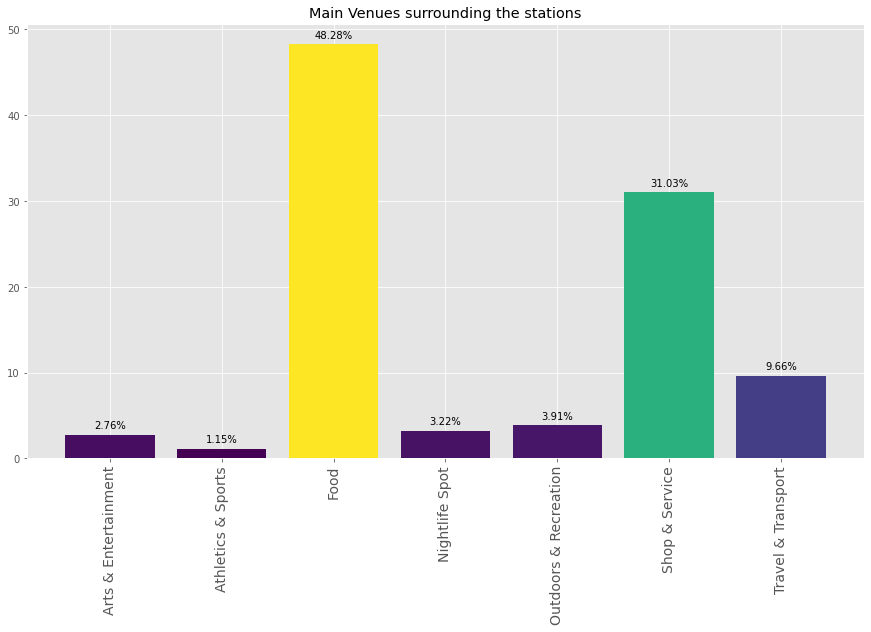

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(15, 8))

total=MainCategory_venues['count'].sum()
count=MainCategory_venues['count'].tolist()
count=np.round((count/total)*100,2)
x = MainCategory_venues.index.tolist()

x_pos = [i for i, _ in enumerate(x)]

#setting color
my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

#setting bar properties
bar = plt.bar(x_pos, count,  color=my_cmap(rescale(count)))
plt.title("Main Venues surrounding the stations")

plt.xticks(x_pos, x,rotation='vertical',fontsize='14')

for p in bar:
    plt.annotate('{}{}'.format(p.get_height(), '%'),
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', 
                 xytext = (0, 9), 
                 textcoords = 'offset points')
#plt.savefig('plot1.png', dpi=300, bbox_inches='tight')
plt.show()

According to the graph most of the venues surrounding the stations are in the category of Food. Now let's what are the most common type of restaurants we can find near the stations.

In [18]:
Restaurants = metro_venues.copy()
Restaurants = Restaurants.loc[Restaurants['Main Category'] == 'Food']
Restaurants['count']=np.full(len(Restaurants),1)
Restaurants=Restaurants.groupby(by=["Venue Category"]).sum()[['count']].reset_index()
Restaurants.sort_values(by='count', ascending=False,inplace=True,ignore_index=True)
Restaurants.head(10)

,Venue Category,count
0,Fast Food Restaurant,24
1,Restaurant,15
2,Sandwich Place,10
3,Coffee Shop,10
4,Italian Restaurant,10
5,Ice Cream Shop,10
6,Pizza Place,9
7,BBQ Joint,9
8,Latin American Restaurant,9
9,Bakery,9


Text(0.5, 1.0, 'Main Food Venues around the Metro Stations')

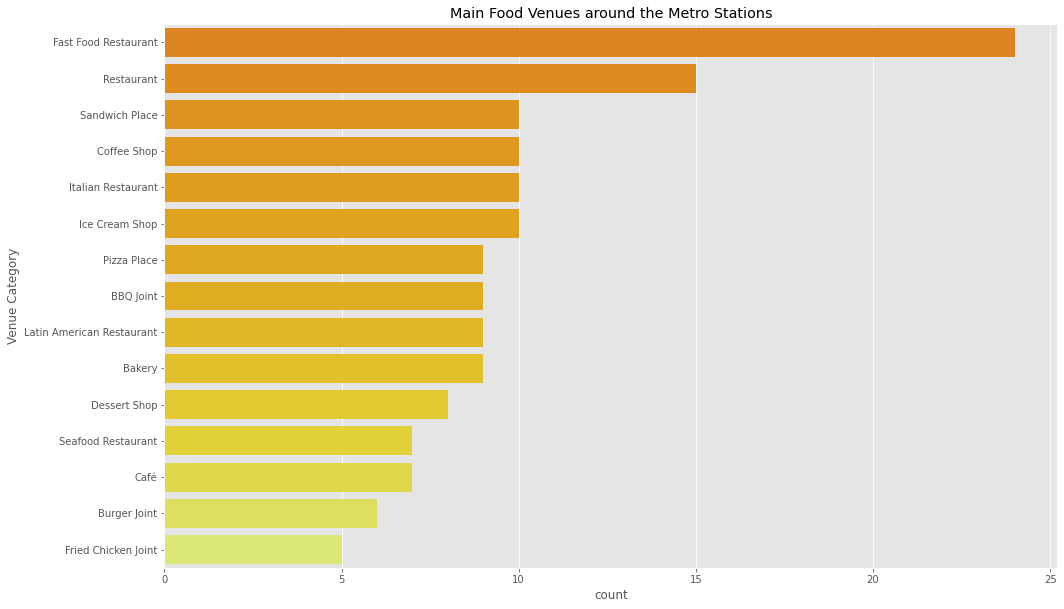

In [19]:
plt.figure(figsize=(16, 10))
food=sns.barplot(x="count",y="Venue Category",data=Restaurants.head(15),palette='Wistia_r')
food.set_title('Main Food Venues around the Metro Stations')
#plt.savefig('plot2.png', dpi=300, bbox_inches='tight')

We can do the same for Shop and Services 

Text(0.5, 1.0, 'Main Shops and Services Venues around the Metro Stations')

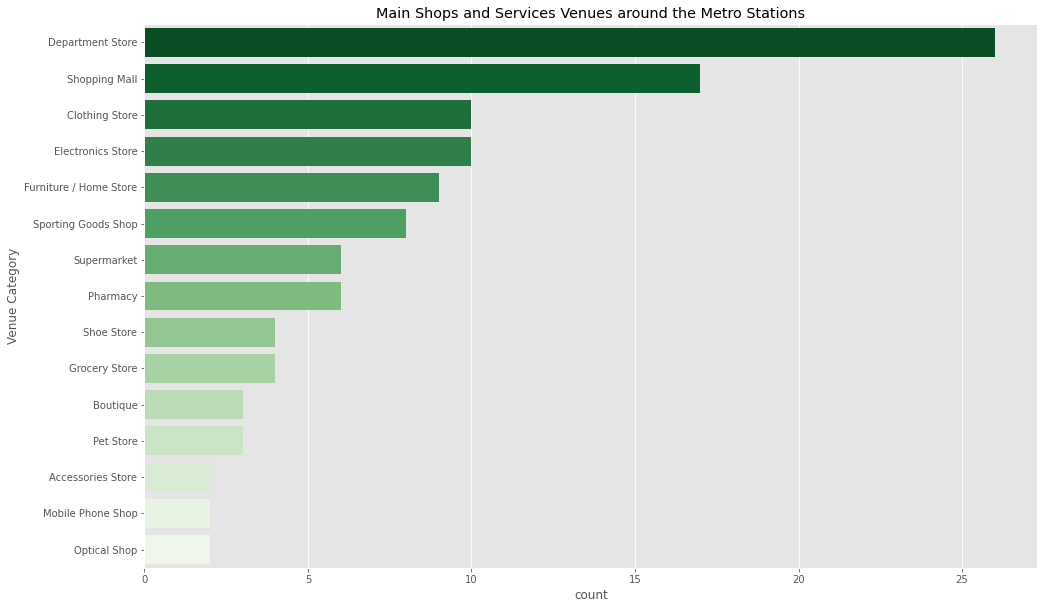

In [20]:
Services = metro_venues.copy()
Services = Services.loc[Services['Main Category'] == 'Shop & Service']
Services['count']=np.full(len(Services),1)
Services=Services.groupby(by=["Venue Category"]).sum()[['count']].reset_index()
Services.sort_values(by='count', ascending=False,inplace=True,ignore_index=True)

plt.figure(figsize=(16, 10))
shop = sns.barplot(x="count",y="Venue Category",data=Services.head(15),palette='Greens_r')
shop.set_title('Main Shops and Services Venues around the Metro Stations')
#plt.savefig('plot3.png', dpi=300, bbox_inches='tight')

###  Analysis of Each Station <a id="item7"></a>

Ok, we saw the main types venues surrounding the stations. Now we can make an analysis of each station, and by this way we can cluster them into groups. We are looking the similarities between them. But before, we need to prepare the data in a better way.

In [21]:
# one hot encoding
Stations_onehot = pd.get_dummies(metro_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Stations_onehot['Neighborhood'] = metro_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Stations_onehot.columns[-1]] + list(Stations_onehot.columns[:-1])
Stations_onehot = Stations_onehot[fixed_columns]

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
Stations_grouped = Stations_onehot.groupby('Neighborhood').mean().reset_index()

Knowing the frequency of occurrence of each category we can set a dataframe with a list of the top 10 common venues en each station. The next function will help us display the top 10 venues for each neighborhood.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Stations_grouped['Neighborhood']

for ind in np.arange(Stations_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Stations_grouped.iloc[ind, :], num_top_venues)

newdf=MetroStations.copy()
newdf=MetroStations[['Station Name','Address']].rename(columns={"Address": "Neighborhood"})
stations_venues_sorted=pd.merge(newdf,neighborhoods_venues_sorted,on='Neighborhood')
stations_venues_sorted

,Station Name,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Estación San Isidro,San Isidro,Department Store,Wings Joint,Diner,Disc Golf,Donut Shop,Electronics Store,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market
1,Estación Los Andés,Los Andés,Department Store,Shoe Store,Clothing Store,Electronics Store,Fast Food Restaurant,Burger Joint,Fried Chicken Joint,Shopping Mall,Movie Theater,Pet Store
2,Estación Pan de Azúcar,Pan de Azúcar,Plaza,Park,Grocery Store,Beach,Hotel Pool,Food Truck,Disc Golf,Donut Shop,Electronics Store,Diner
3,Estación San Miguelito,Vía Simón Bolívar,Department Store,Sporting Goods Shop,Furniture / Home Store,Supermarket,Coffee Shop,Fast Food Restaurant,Wings Joint,Flea Market,Food Court,Flower Shop
4,Estación Pueblo Nuevo,Pueblo Nuevo,Dessert Shop,Department Store,Diner,Disc Golf,Donut Shop,Electronics Store,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market
5,Estación 12 de Octubre,12 de Octubre,Food Truck,Restaurant,BBQ Joint,Martial Arts School,Fish & Chips Shop,Wings Joint,Fish Market,Food Court,Flower Shop,Flea Market
6,Estación El Ingenio,El Ingenio,Fast Food Restaurant,Paper / Office Supplies Store,Music Store,Rental Service,Latin American Restaurant,Bar,Furniture / Home Store,Seafood Restaurant,Flea Market,Fish Market
7,Estación Fernández de Córdoba,Vía Fernández de Córdoba,Furniture / Home Store,Ice Cream Shop,Latin American Restaurant,Sandwich Place,Chinese Restaurant,Gym,Breakfast Spot,BBQ Joint,Hostel,Food Court
8,Estación Vía Argentina,Vía Argentina,Hotel,Electronics Store,Italian Restaurant,Restaurant,Seafood Restaurant,Burger Joint,Pizza Place,Spa,Cuban Restaurant,Speakeasy
9,Estación Iglesia del Carmen,Vía España,Hotel,Italian Restaurant,Restaurant,Café,Coffee Shop,Spanish Restaurant,Vegetarian / Vegan Restaurant,Hotel Bar,French Restaurant,Food Truck


### K-Means Clustering Method <a id="item8"></a>

K-Means can help us group data based on the similarity of the stations to each other. In this way we could better classify the stations according to the venues that are common between them. First, we have to determine the number of clusters or K in K-Means, for that I'm going to use the elbow method. Therefore, I could use this graph that compares the metric of accuracy, to select the best K that could suit the model.

#### Elbow Curve

Text(0.5, 1.0, 'Elbow curve')

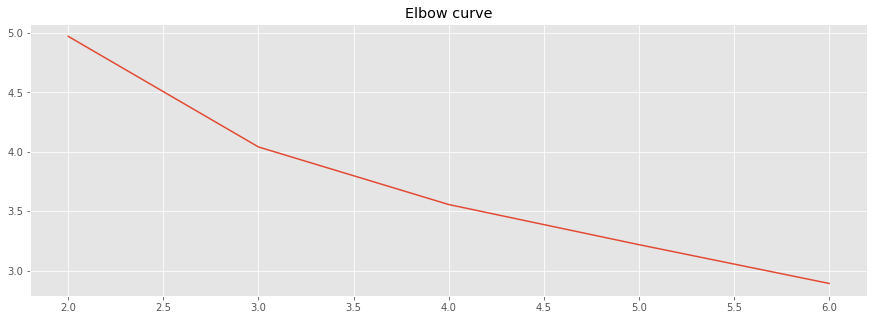

In [25]:
X = Stations_grouped.drop('Neighborhood', 1)
distorsions = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 7), distorsions)
plt.grid(True)
plt.title('Elbow curve')
#plt.savefig('plot4.png', dpi=300, bbox_inches='tight')

The inertia attribute of K-means identifies the sum of squared distances of samples to the nearest cluster center. That grade of distortion help us identify that k=3 could best to option to run the model

#### Clustering the Stations

In [26]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 1, 1, 0, 1, 1, 0, 1], dtype=int32)

In [27]:
# add clustering labels
neighborhoods_venues_sorted2=neighborhoods_venues_sorted.copy()
neighborhoods_venues_sorted2.insert(0, 'Cluster Labels', kmeans.labels_)

MetroStation_merged = MetroStations

MetroStation_merged = MetroStation_merged.join(neighborhoods_venues_sorted2.set_index('Neighborhood'), on='Address')

MetroStation_merged

,Station Name,Latitude,Longitude,Address,Line,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Estación San Isidro,9.064168,-79.511222,San Isidro,1,2,Department Store,Wings Joint,Diner,Disc Golf,Donut Shop,Electronics Store,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market
1,Estación Los Andés,9.049284,-79.507917,Los Andés,1,1,Department Store,Shoe Store,Clothing Store,Electronics Store,Fast Food Restaurant,Burger Joint,Fried Chicken Joint,Shopping Mall,Movie Theater,Pet Store
2,Estación Pan de Azúcar,9.039393,-79.507193,Pan de Azúcar,1,0,Plaza,Park,Grocery Store,Beach,Hotel Pool,Food Truck,Disc Golf,Donut Shop,Electronics Store,Diner
3,Estación San Miguelito,9.029793,-79.506298,Vía Simón Bolívar,1,2,Department Store,Sporting Goods Shop,Furniture / Home Store,Supermarket,Coffee Shop,Fast Food Restaurant,Wings Joint,Flea Market,Food Court,Flower Shop
4,Estación Pueblo Nuevo,9.023588,-79.511665,Pueblo Nuevo,1,2,Dessert Shop,Department Store,Diner,Disc Golf,Donut Shop,Electronics Store,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market
5,Estación 12 de Octubre,9.016473,-79.517154,12 de Octubre,1,0,Food Truck,Restaurant,BBQ Joint,Martial Arts School,Fish & Chips Shop,Wings Joint,Fish Market,Food Court,Flower Shop,Flea Market
6,Estación El Ingenio,9.008014,-79.519207,El Ingenio,1,1,Fast Food Restaurant,Paper / Office Supplies Store,Music Store,Rental Service,Latin American Restaurant,Bar,Furniture / Home Store,Seafood Restaurant,Flea Market,Fish Market
7,Estación Fernández de Córdoba,8.999000,-79.519844,Vía Fernández de Córdoba,1,1,Furniture / Home Store,Ice Cream Shop,Latin American Restaurant,Sandwich Place,Chinese Restaurant,Gym,Breakfast Spot,BBQ Joint,Hostel,Food Court
8,Estación Vía Argentina,8.989559,-79.522211,Vía Argentina,1,1,Hotel,Electronics Store,Italian Restaurant,Restaurant,Seafood Restaurant,Burger Joint,Pizza Place,Spa,Cuban Restaurant,Speakeasy
9,Estación Iglesia del Carmen,8.982299,-79.527076,Vía España,1,0,Hotel,Italian Restaurant,Restaurant,Café,Coffee Shop,Spanish Restaurant,Vegetarian / Vegan Restaurant,Hotel Bar,French Restaurant,Food Truck


Finally, let's display the map and visualize the resulting clusters.

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MetroStation_merged['Latitude'], MetroStation_merged['Longitude'], MetroStation_merged['Station Name'], MetroStation_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster Characteristics <a id="item9"></a>

Good! Now the stations are cluster. But we want to see what places characterize each cluster. We can set a new dataframe using metro_venues and MetroStation_merged. Then we merge them and reorder it.

In [29]:
Clabel=MetroStation_merged[['Address','Cluster Labels']].rename(columns={"Address": "Neighborhood"})
Clusters= metro_venues[['Neighborhood','Venue Category','Main Category']]
Clusters=pd.merge(Clusters,Clabel,on='Neighborhood')
Clusters.head()

,Neighborhood,Venue Category,Main Category,Cluster Labels
0,San Isidro,Department Store,Shop & Service,2
1,Los Andés,Fast Food Restaurant,Food,1
2,Los Andés,Clothing Store,Shop & Service,1
3,Los Andés,Fast Food Restaurant,Food,1
4,Los Andés,Movie Theater,Arts & Entertainment,1


In [30]:
def ClusterClass(cluster_number,Clusters):
    cluster = Clusters.loc[Clusters['Cluster Labels'] == cluster_number].reset_index(drop=True)
    cluster['count']=np.full(len(cluster),1)
    cluster=cluster.groupby(by=['Venue Category']).sum()[['count']].reset_index()
    cluster.sort_values(by='count', ascending=False,inplace=True,ignore_index=True)
    cluster = cluster.head()
    total=cluster['count'].sum()
    count=cluster['count'].tolist()
    cluster['percentage']=np.round((count/total)*100,2)
    return cluster

Cluster0 = ClusterClass(0,Clusters)
Cluster1 = ClusterClass(1,Clusters)
Cluster2 = ClusterClass(2,Clusters)

Let's prepare the graphs. I'm going to select only the top 5 type of venues for each cluster.

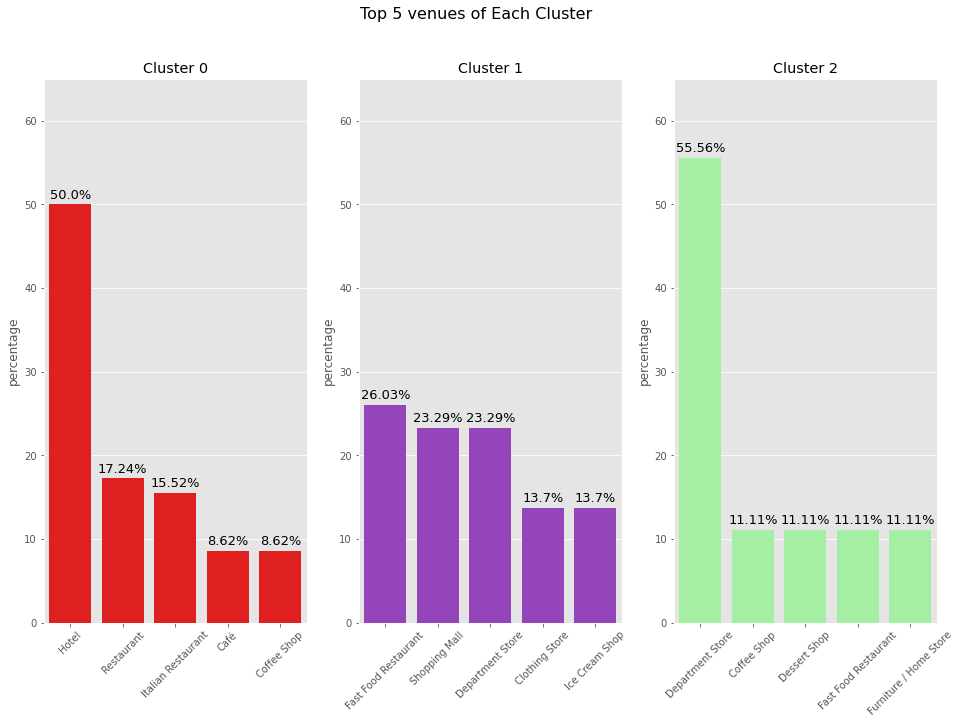

In [31]:
fig = plt.figure(figsize=(16,10)) # create figure
fig.suptitle('Top 5 venues of Each Cluster',fontsize=16)

ax0 = fig.add_subplot(1, 3, 1) # add subplot 1 (1 row, 3 columns, first plot)
ax1 = fig.add_subplot(1, 3, 2) # add subplot 2 (1 row, 3 columns, second plot). 
ax2 = fig.add_subplot(1, 3, 3) # add subplot 2 (1 row, 3 columns, second plot). 

# Subplot 1: 
bar1=sns.barplot(x="Venue Category",y="percentage",data=Cluster0,ax=ax0,color='Red')
ax0.set_title('Cluster 0')
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=45)
ax0.set_xlabel({}).set_visible(False)
ax0.set_ylim(0,65)

# Subplot 2: 
bar2=sns.barplot(x="Venue Category",y="percentage",data=Cluster1,ax=ax1,color='darkorchid')
ax1.set_title('Cluster 1')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
ax1.set_xlabel({}).set_visible(False)
ax1.set_ylim(0,65)

# Subplot 3: 
bar3=sns.barplot(x="Venue Category",y="percentage",data=Cluster2,ax=ax2,color='palegreen')
ax2.set_title('Cluster 2')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
ax2.set_xlabel({}).set_visible(False)
ax2.set_ylim(0,65)

def autolabel(bar):
    for b in bar.patches:
        height = b.get_height()
        bar.annotate('{}{}'.format(height,'%'),
                    xy=(b.get_x() + b.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize='13')
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

#plt.savefig('plot5.png', dpi=300, bbox_inches='tight')
plt.show()

### 4. Results and Discussion<a id="item10"></a>

The Red Cluster is composed mostly of hotel areas. Meaning that if I want to find a hotel in the city close to metro stations, is most probably that I’m going to find them in the area of Santo Tomas Station or Iglesia del Carmen Station, as is indicated in the map on the first 2 red labels in the city. Then we can see that the Purple Cluster is characterized mostly by fast food restaurants and shopping malls. The green one is composed mostly of department stores.

I can say that it has been a considerable approach and as I mentioned before, the model could have a certain scope due to the limitation of the data that we have. While Foursquare API might not take all of the actual venues existing around because it offers data of places limit by the information registered by the users, also Panama, as a growing country, should also consider working much more on its databases in general. For business investors for sure localization is one important variable to consider at the moment of opening a business, but certainly, it will be interesting to have more variable to study, like the average renting prices of each area, the crime rate of each area, and others more that could be considered in the future with a strong database. 

### 5. Conclusion<a id="item11"></a>